In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
sns.set(color_codes=True)

## Dataset
Hơn 20 000 ván đấu cờ vua online trên hệ thống Lichess.org bao gồm các nước đi, rating, khai cuộc,...

In [3]:
games_df = pd.read_csv('games.csv')
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 1.6+ MB


In [4]:
games_df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Phân bố average rating của các ván đấu

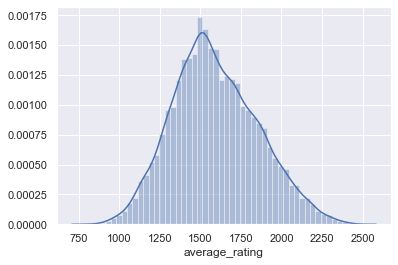

In [5]:
games_df['average_rating'] = (games_df['white_rating']+games_df['black_rating'])//2
sns.distplot(games_df['average_rating'])
plt.show()

Rating trung bình của những ván đấu thường vào khoảng 1500

## Phân bố số nước đi trung bình của một ván đấu

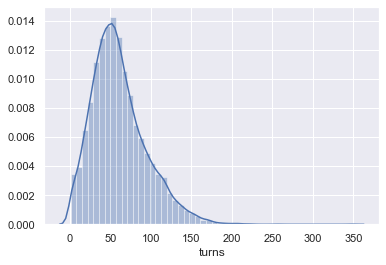

In [6]:
sns.distplot(games_df['turns'])
plt.show()

## Những lựa chọn cho nước đi đầu tiên

In [7]:
games_df = games_df.assign(first_move = lambda row: row['moves'].str.split(' ').str[0])

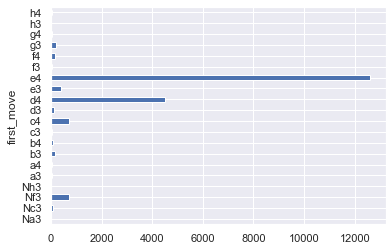

In [8]:
first_move_df = games_df.groupby('first_move').size()
first_move_df.plot(kind='barh')
plt.show()

Như vậy nước e4 là nước cờ được lựa chọn nhiều nhất khi bắt đầu ván cờ
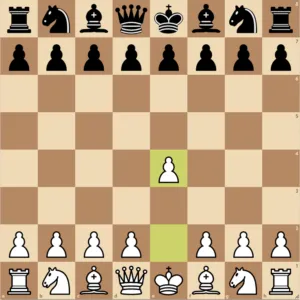 **1. e4 King's pawn opening**  
Ngoài ra nước d4 cũng khá được ưa chuộng

## Top 20 khai cuộc thông dụng nhất

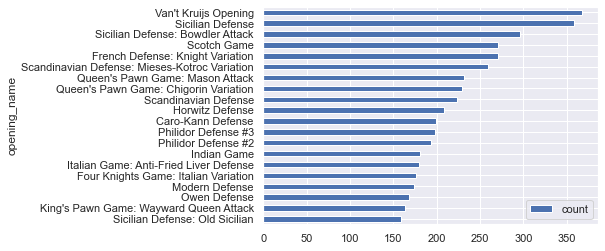

In [9]:
#top_20_common_opening = 
games_df.groupby(['opening_name'])['opening_name'].agg(['count']).sort_values(by = 'count',ascending = False).head(20).sort_values(by = 'count',ascending = True).plot(kind ='barh')#.sort_values(ascending = False).head(20)
#top_20_common_opening_df.plot.barh()
plt.show()

### Tỉ lệ thắng của các bên

In [10]:
winner_by_opening_df = games_df.groupby(['opening_name','winner']).size()
winner_by_opening_df

opening_name                     winner
Alekhine Defense                 black     21
                                 draw       2
                                 white     23
Alekhine Defense #2              black      1
                                 draw       1
                                           ..
Zukertort Opening: The Walrus    white      1
Zukertort Opening: Vos Gambit    black      1
                                 draw       1
                                 white      1
Zukertort Opening: Wade Defense  black      1
Length: 2739, dtype: int64

In [11]:
winner_by_opening_df_uns = winner_by_opening_df.unstack().dropna()
winner_by_opening_df_uns['sum']=winner_by_opening_df_uns['black']+winner_by_opening_df_uns['white']+winner_by_opening_df_uns['draw']
winner_by_opening_df_uns['black_winrate']= winner_by_opening_df_uns['black']/winner_by_opening_df_uns['sum']*100
winner_by_opening_df_uns['white_winrate']= winner_by_opening_df_uns['white']/winner_by_opening_df_uns['sum']*100
winner_by_opening_df_uns['draw_rate']= winner_by_opening_df_uns['draw']/winner_by_opening_df_uns['sum']*100
winrate_by_opening_df = winner_by_opening_df_uns.sort_values(by = 'sum',ascending=False).head(20)[['black_winrate','white_winrate','draw_rate']]
cm = sns.light_palette("green", as_cmap=True)
winrate_by_opening_df.style.background_gradient(cmap=cm)

winner,black_winrate,white_winrate,draw_rate
opening_name,,,
Van't Kruijs Opening,61.413043,34.239130,4.347826
Sicilian Defense,54.189944,41.620112,4.189944
Sicilian Defense: Bowdler Attack,55.405405,40.202703,4.391892
French Defense: Knight Variation,44.649446,49.815498,5.535055
Scotch Game,42.435424,53.505535,4.059041
Scandinavian Defense: Mieses-Kotroc Variation,34.362934,63.320463,2.316602
Queen's Pawn Game: Mason Attack,44.396552,50.000000,5.603448
Queen's Pawn Game: Chigorin Variation,47.598253,48.908297,3.493450
Scandinavian Defense,55.156951,40.358744,4.484305


### Những khai cuộc và số lượt đi trung bình trong ván đấu

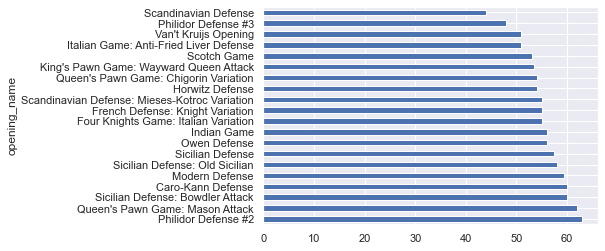

In [12]:
top_20_count_opening_average_moves_df = games_df.groupby('opening_name')['turns'].agg([np.median,'count']).sort_values(by = ['count'],ascending = [False]).head(20)
top_20_count_opening_average_moves_df['median'].sort_values(ascending = False).plot(kind = 'barh')
plt.show()

Dễ dàng thấy được Scandinavian Defense là khai cuộc mà trận đấu kết thúc nhanh nhất còn Philidor Defense #2 là khai cuộc mà ván đấu thường kéo dài nhất

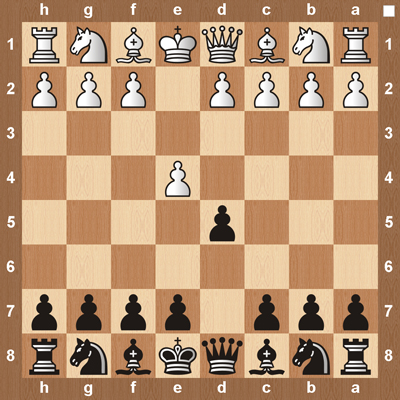 **Scandinavian Defense**

### Tỉ lệ thắng của bên có rating cao hơn trong một ván đấu

In [13]:
def isHigherRatingWins(row):
    if row.winner == 'black':
        if row.black_rating> row.white_rating:
            return True
        else:
            return False
    else:
        if row.black_rating> row.white_rating:
            return False
        else:
            return True
        

In [14]:
games_df['higher_wins'] = games_df.apply(isHigherRatingWins,axis = 1)
games_df

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,average_rating,first_move,higher_wins
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,1345,d4,True
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,1291,d4,False
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,1498,e4,False
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,1446,d4,False
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,1496,e4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,1.499791e+12,1.499791e+12,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2,1455,d4,True
20054,WSJDhbPl,True,1.499698e+12,1.499699e+12,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2,1214,d4,False
20055,yrAas0Kj,True,1.499698e+12,1.499698e+12,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3,1252,d4,False
20056,b0v4tRyF,True,1.499696e+12,1.499697e+12,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4,1293,e4,True


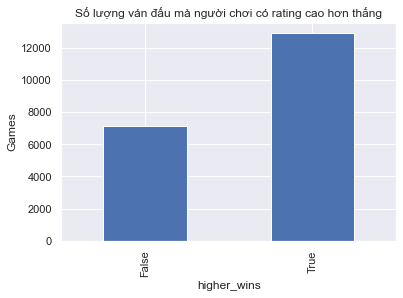

In [15]:
higher_rating_wins = games_df.groupby('higher_wins').size()
higher_rating_wins.plot(kind = 'bar', ylabel = 'Games',title = 'Số lượng ván đấu mà người chơi có rating cao hơn thắng')
plt.show()

Nhìn vào biểu đồ ta dễ dàng thấy số lượng ván đấu mà người chơi có rating cao hơn thắng so là gần gấp đôi so với số ván đấu mà người chơi có rating thấp hơn thắng

Ta thử phân tích xem những ván mà người chơi rating thấp hơn thắng họ thường sử dụng những khai cuộc nào

### Khai cuộc trong các ván đấu mà người chơi có rating thấp hơn thắng

In [16]:
lower_rating_wins_games_df = games_df[games_df['higher_wins']==False]
opening_used_by_lower_rating = lower_rating_wins_games_df.groupby('opening_name').size().sort_values(ascending = False).head(20)

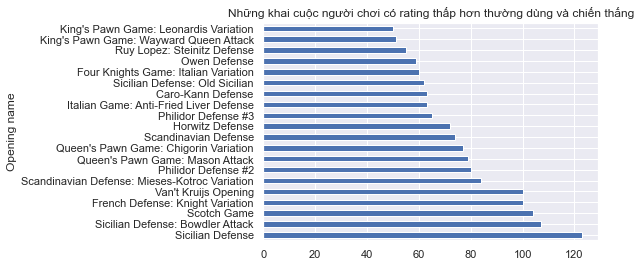

In [17]:
opening_used_by_lower_rating.plot(kind= 'barh', ylabel='Games',xlabel='Opening name',title='Những khai cuộc người chơi có rating thấp hơn thường dùng và chiến thắng')
plt.show()

Nhìn vào biểu đồ ta thấy, với một người có rating thấp hơn thì những khai cuộc như Sicilian Defense với các biến thể của nó, Scotch Game và French Defense là một sự lựa chọn tốt khi phải đối đầu với người chơi có trình độ cao hơn

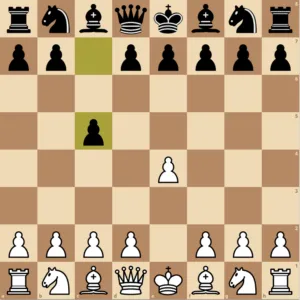 **Sicilian Defense**

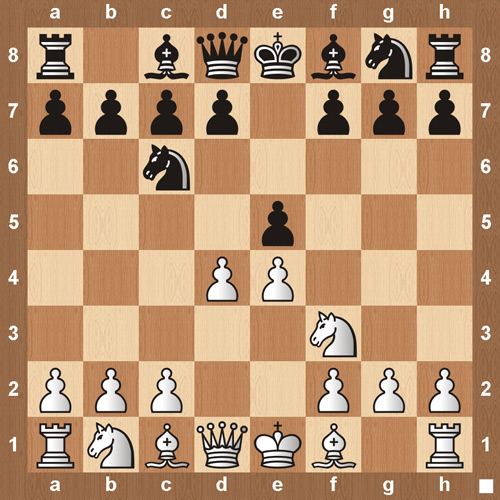 **Scotch game**

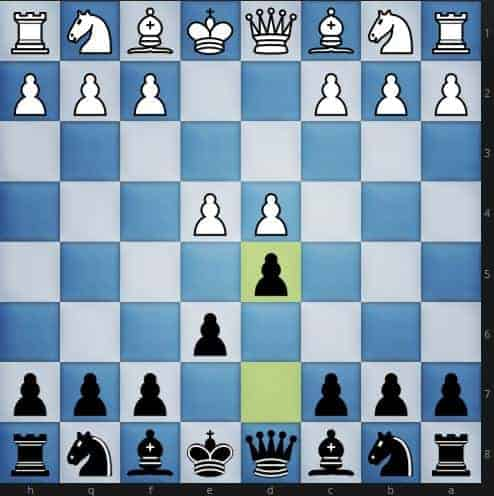 **French Defense**

## Khai cuộc của những ván đấu rating cao (average_rating >2000)

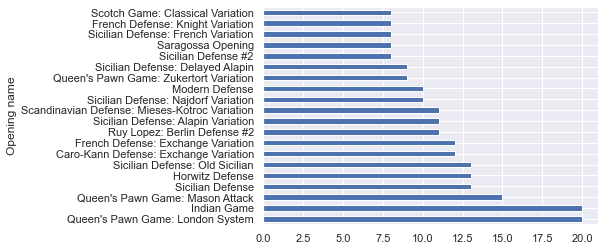

In [18]:
gt_2000_games_df = games_df[games_df['average_rating']>2000]
opening_gt_2000_df = gt_2000_games_df.groupby('opening_name').size().sort_values(ascending = False)
opening_gt_2000_df.head(20).plot(kind='barh',xlabel ='Opening name')
plt.show()

Với tầm rating cao thì những khai cuộc như Queen's Pawn Game: London System và Indian Game thường được ưa chuộng

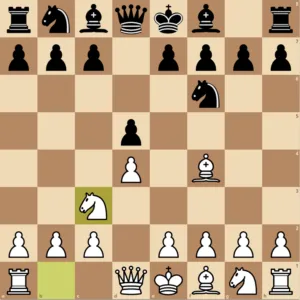**London system**

Qua bài phân tích trên, hi vọng các bạn có thể tìm được một khai cuộc trong cờ vua mà mình thích cũng như lựa chọn một đối pháp hợp lí cho đối thủ của mình